# Removing ? in sleep grid and other things

In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Legit Users

In [2]:
legit_users_df = pd.read_excel('data/legit_watches.xlsx').dropna(subset=['userId'])
legit_users = list(legit_users_df['userId'])
print(f'num of legitimate users: {len(legit_users)}\nexample:')
legit_users[:3]

num of legitimate users: 145
example:


['0793ab56-25e1-4b0b-9a9b-be573b682523',
 '307267de-8ea3-4a7d-bc7f-5ae71f38e5e6',
 'b49795a3-5fe2-4233-b27c-fe02363e04a1']

## Calculating Min and Max Heart Rates

needs heart_rate_grid.pkl and the two fitness test spreadsheets in data folder named spreadsheet1.xlsw and spreadsheet2.xlsw

In [3]:
with open('heart_rate_grid.pkl', 'rb') as file:
    heart_rate = pickle.load(file)

In [4]:
# example usage of heart_rate
soldID = '00a7a796-c572-44d7-a950-7f6bca4a4394'
print(f'HR recorded weeks: {heart_rate[soldID].keys()}')
heart_rate[soldID][35].head()
# weeks:  4, 35, 36, 50, 51

HR recorded weeks: dict_keys([4, 35, 36, 50, 51])


,userId,dailiessummaryId,pulse,datetime,WeekNumber
0,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:15,35
1,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:30,35
2,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:20:45,35
3,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:00,35
4,00a7a796-c572-44d7-a950-7f6bca4a4394,x48cc04e-6313c050-15180-6,83,2022-09-04 09:21:15,35


min hr

In [6]:
# min hr: 5 percentile
percentile_5_hrs = {}
min_avg_hrs = {}
for soldier_id, weekly_data in heart_rate.items():
    daily_percentile_5_hr = []
    for week, df in weekly_data.items():
        df['date'] = df['datetime'].dt.date  # Extract date part from datetime
        daily_groups = df.groupby('date')  # Group by date
        for date, group in daily_groups:
            percentile_5 = np.percentile(group['pulse'], 5)  # Calculate 5th percentile for the day's heart rates
            daily_percentile_5_hr.append(percentile_5)
    percentile_5_hrs[soldier_id] = daily_percentile_5_hr
    min_avg_hrs[soldier_id] = np.median(daily_percentile_5_hr)
print(f'Average min hr across all soldiers: {np.average(list(min_avg_hrs.values()))}')

legit_hr_values = [min_avg_hrs[user_id] for user_id in legit_users if user_id in min_avg_hrs]
print(f'Average min hr across legit users: {np.average(legit_hr_values)}')

Average min hr across all soldiers: 59.06726190476191
Average min hr across legit users: 58.32314814814815


In [7]:
# example
percentile_5_hrs['00a7a796-c572-44d7-a950-7f6bca4a4394'] # each entry corresponds to a day

[87.0, 60.0, 79.0, 70.0, 47.0, 50.0, 46.0, 77.0, 60.1, 71.0]

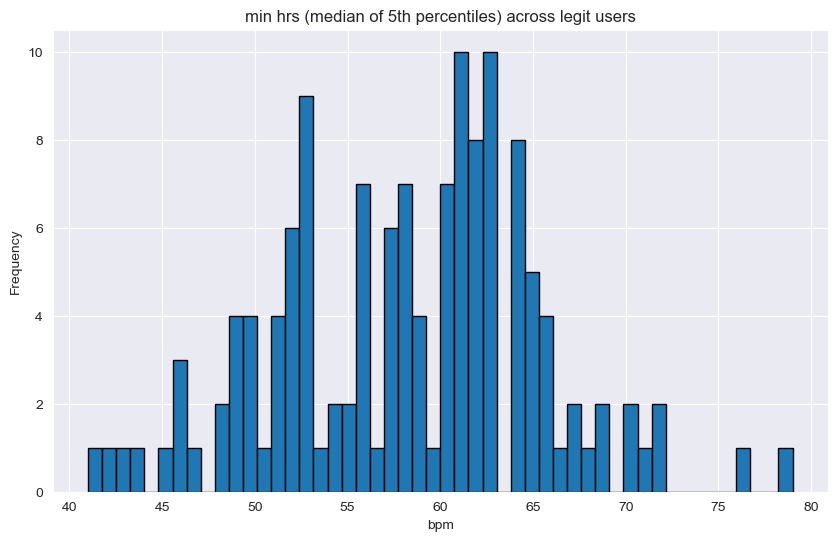

In [8]:
# graph
plt.figure(figsize=(10, 6))
plt.hist(legit_hr_values, bins=50, edgecolor='black')
plt.title('min hrs (median of 5th percentiles) across legit users')
plt.xlabel('bpm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [98]:
# getting the dates of the fitness tests -> union_dates
import datetime
def convert_unix_to_datetime(unix_timestamp):
    return datetime.datetime.fromtimestamp(unix_timestamp)

df1 = pd.read_excel('data/spreadsheet1.xlsx')
df2 = pd.read_excel('data/spreadsheet2.xlsx')
df1['date'] = pd.to_datetime(df1['date']).apply(lambda x: x.date())
df2['date'] = pd.to_datetime(df2['date']).apply(lambda x: x.date())
dates1 = df1['date'].dropna()
dates2 = df2['date'].dropna()
union_dates = pd.concat([df1['date'], df2['date']]).drop_duplicates().dropna().reset_index(drop=True)
print(f'number of dates in fitness test: {len(union_dates)}')
# set(union_dates)

number of dates in fitness test: 117


max hr

In [120]:
# calculating max hr: 99.5 percentile 
percentile_99_5_hrs = {}
max_avg_hrs = {}
min_samples = 500

union_dates_set = set(union_dates)
# union_dates_set = {datetime.date(2022, 9, 15)}  # test with individual date/s; (year, month, day)

for soldier_id, weekly_data in heart_rate.items():
    daily_percentile_99_5_hr = []
    for week, df in weekly_data.items():
        df['date'] = df['datetime'].dt.date  # Extract date part from datetime
        daily_groups = df.groupby('date')  # Group by date
        for date, group in daily_groups:
            # print(len(group)) # group is the df with the hr on the date for soldier_id
            # uncomment an 'if' and use
            if date in union_dates_set and len(group) > min_samples:  # fitness dates only
            # if len(group) > min_samples:  # all dates
            # if date not in union_dates_set and len(group) > min_samples:  # no fitness dates
            # if True:  # all dates and any size of group
                percentile_99_5 = np.percentile(group['pulse'], 99.5)  # Calculate 95th percentile for the day's heart rates
                daily_percentile_99_5_hr.append(percentile_99_5)
    percentile_99_5_hrs[soldier_id] = daily_percentile_99_5_hr
    if len(daily_percentile_99_5_hr):  # no divide by zero error
        max_avg_hrs[soldier_id] = np.median(daily_percentile_99_5_hr)

print(f'average max hr across all soldiers: {np.average(list(max_avg_hrs.values()))}')
print(f'num of soldiers with no data: {len(heart_rate.keys()) - len(max_avg_hrs.keys())}')

average max hr across all soldiers: 123.88335106382979
num of soldiers with no data: 69


In [111]:
# print the soldiers with their max hr
df_max_avg_hrs = pd.DataFrame.from_dict(max_avg_hrs, orient='index', columns=['max_hr'])
df_max_avg_hrs.reset_index(inplace=True)
df_max_avg_hrs.rename(columns={'index': 'soldier_id'}, inplace=True)
df_max_avg_hrs

,soldier_id,max_hr
0,00a7a796-c572-44d7-a950-7f6bca4a4394,123.0000
1,02a9bd9f-430e-4351-b1e7-9ae10b9413a3,132.0000
2,03406515-0b5e-4a5a-9ff1-a85c06513e60,138.0000
3,042e1305-faa2-4eb8-a833-d2181efdeb31,117.0000
4,050b5881-43e2-44c8-8964-148576d30359,123.5000
...,...,...
136,facdd015-3ab6-4dca-8c12-4fc3c008679e,121.0000
137,fbfa150b-4c62-412d-9e84-ef06e8495fc5,114.6825
138,fd486705-4873-4001-95f5-6f5bbf0d620f,140.0000
139,fd949638-b68e-4e68-b660-f31133ed2a19,104.0000


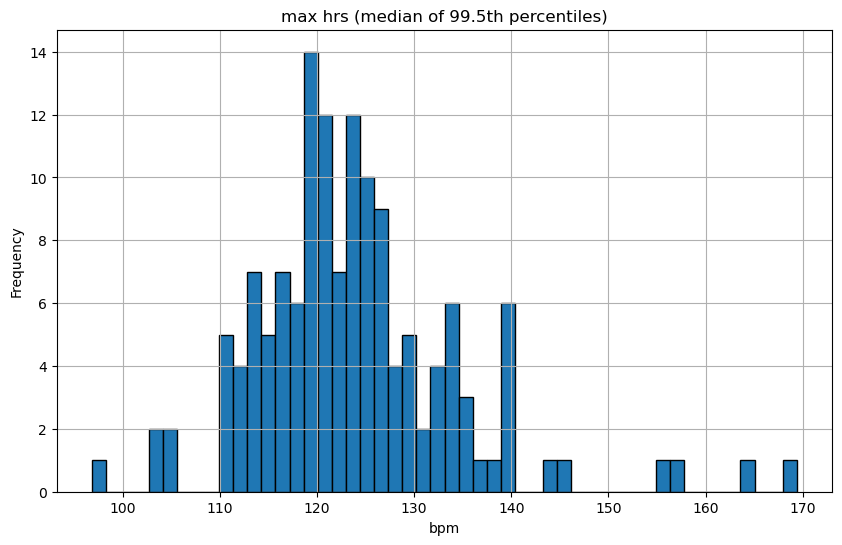

In [107]:
# graph
median_values = list(max_avg_hrs.values())

plt.figure(figsize=(10, 6))
plt.hist(median_values, bins=50, edgecolor='black')
plt.title('max hrs (median of 99.5th percentiles)')
plt.xlabel('bpm')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [128]:
# soldID = 'ba6e4cf9-b8f2-49a1-890e-5093d32a456e'
soldID = 'b810cc55-65f1-45fa-94fe-e28b8066cd01'
print(f'max hr for \'{soldID}\' is {max_avg_hrs[soldID]} bpm')
print('HR 99.5th percentile per day:')
# percentile_99_5_hrs[soldID].sort()
percentile_99_5_hrs[soldID]

max hr for 'b810cc55-65f1-45fa-94fe-e28b8066cd01' is 122.0 bpm
HR 99.5th percentile per day:


[139.0,
 110.0,
 147.0,
 112.0,
 118.0,
 122.0,
 121.0,
 187.0,
 174.0,
 120.0,
 169.0,
 164.0,
 82.0,
 137.0,
 116.0]

In [122]:
heart_rate[soldID][36]
# weeks: [2, 3, 4, 34, 35, 40, 42, 43, 44, 45, 46, 47, 48, 49]

,userId,dailiessummaryId,pulse,datetime,WeekNumber,date
0,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:15:15,36,2022-09-15
1,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:15:30,36,2022-09-15
2,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:15:45,36,2022-09-15
3,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,67,2022-09-15 14:16:00,36,2022-09-15
4,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:20:15,36,2022-09-15
5,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:20:30,36,2022-09-15
6,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:20:45,36,2022-09-15
7,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,69,2022-09-15 14:21:00,36,2022-09-15
8,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,83,2022-09-15 14:21:15,36,2022-09-15
9,b810cc55-65f1-45fa-94fe-e28b8066cd01,x48c438e-632240d0-15180-6,83,2022-09-15 14:21:30,36,2022-09-15


## steps with zones and binary sleep grid

In [9]:
with open('heart_rate_grid.pkl', 'rb') as file:
    heart_rate = pickle.load(file)  # 15 second intervals

In [10]:
# making heart rate grids be by 1 minute, and not 15 seconds
downsampled_heart_rate = {}

for soldier_id, weekly_data in heart_rate.items():
    downsampled_heart_rate[soldier_id] = {}
    for week, df in weekly_data.items():
        df_copy = df.copy()
        # TODO bug in heart_rate, see july 20 in google docs for details
        df_copy.drop_duplicates(subset=['datetime'], inplace=True)
        df_copy.set_index('datetime', inplace=True)  # Set datetime as the index for resampling
        resampled_df = df_copy.resample('1min').mean(numeric_only=True).dropna().reset_index()   # Resample to 1 minute intervals and take the mean
        resampled_df.reset_index(drop=True, inplace=True)  # Reset the index to make datetime a column again
        resampled_df['WeekNumber'] = resampled_df['WeekNumber'].astype('int64')
        downsampled_heart_rate[soldier_id][week] = resampled_df
        

In [13]:
soldier = 'd8dde847-b55a-4a8b-97a3-db7f53a07ec9'
# soldier = '00a7a796-c572-44d7-a950-7f6bca4a4394'
print(f'soldier is in legit users: {soldier in legit_users}')

soldier is in legit users: True


In [16]:
heart_rate[soldier][36].head(10)

,userId,dailiessummaryId,pulse,datetime,WeekNumber
0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,82,2022-09-11 11:44:15,36
1,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,82,2022-09-11 11:44:30,36
2,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,82,2022-09-11 11:44:45,36
3,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,82,2022-09-11 11:45:00,36
4,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,75,2022-09-11 11:45:15,36
5,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,75,2022-09-11 11:45:30,36
6,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,75,2022-09-11 11:45:45,36
7,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,75,2022-09-11 11:46:00,36
8,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,89,2022-09-11 11:46:15,36
9,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,x48c7c66-631cf044-15180-6,89,2022-09-11 11:46:30,36


In [18]:
downsampled_heart_rate[soldier][36].head(4)

,datetime,pulse,WeekNumber
0,2022-09-11 11:44:00,82.00,36
1,2022-09-11 11:45:00,76.75,36
2,2022-09-11 11:46:00,85.50,36
3,2022-09-11 11:47:00,88.25,36


steps

note: the steps when upsampling get propagated 

In [19]:
with open('steps_grid.pkl', 'rb') as file:
    steps_grid = pickle.load(file)  # 15 minute intervals

In [20]:
# resampling steps to be 1 minute interval from 15 minute interval
heart_rate_zones = [60, 100, 130, 150, 170, 175]  # example hr zones

def get_hr_zone(hr, zones):
    if pd.isna(hr):
        return np.nan
    for i, zone in enumerate(zones):
        if hr < zone:
            return i
    return len(zones)

upsampled_steps = {}  # 1 minute intervals

for user_id, weekly_data in steps_grid.items():     
    upsampled_steps[user_id] = {}
    for week, df_steps in weekly_data.items():
        df_steps_copy = df_steps.copy()
        # Duplicate last row so it will upsample last row
        last_row = df_steps_copy.tail(1).copy()
        last_row['startTimeLocal'] = last_row['startTimeLocal'] + pd.Timedelta(minutes=14)        
        df_steps_copy = pd.concat([df_steps_copy, last_row], ignore_index=True)
        df_steps_copy.set_index('startTimeLocal', inplace=True)
        resampled_steps_df = df_steps_copy.resample('1min').ffill().reset_index()  # Forward fill to upsample to 1-minute intervals
        
        # Get corresponding heart rate data
        df_heart_rate = pd.DataFrame(columns=['datetime','pulse'])
        if user_id in downsampled_heart_rate.keys() and week in downsampled_heart_rate[user_id].keys():
            df_heart_rate = downsampled_heart_rate[user_id][week]
            
        # Merge steps data with heart rate data
        merged_df = pd.merge(resampled_steps_df, df_heart_rate, left_on='startTimeLocal', right_on='datetime', how='left')
        # Assign heart rate zones
        merged_df['HR_zone'] = merged_df['pulse'].apply(lambda x: get_hr_zone(x, heart_rate_zones))
        
        # Set HR_zone to 0 if distanceInMeters is 0
        merged_df.loc[merged_df['distanceInMeters'] == 0, 'HR_zone'] = 0
        
        # Drop unnecessary columns and reset index
        # merged_df = merged_df[['startTimeLocal', 'steps', 'userId', 'activeTimeInSeconds', 'distanceInMeters', 'speed', 'is_running', 'HR_zone']]
        merged_df = merged_df[['startTimeLocal', 'userId', 'HR_zone','pulse', 'steps']]
        
        upsampled_steps[user_id][week] = merged_df
        

In [21]:
steps_grid[soldier][35]

,startTimeLocal,steps,userId,activeTimeInSeconds,distanceInMeters,speed,is_running
0,2022-09-04 00:00:00,7,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,5.54,0.3324,False
1,2022-09-04 00:15:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False
2,2022-09-04 00:30:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False
3,2022-09-04 00:45:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False
4,2022-09-04 01:00:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False
...,...,...,...,...,...,...,...
667,2022-09-10 22:45:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False
668,2022-09-10 23:00:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False
669,2022-09-10 23:15:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False
670,2022-09-10 23:30:00,0,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,900,0.00,0.0000,False


In [22]:
upsampled_steps[soldier][35]

,startTimeLocal,userId,HR_zone,pulse,steps
0,2022-09-04 00:00:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,54.50,7
1,2022-09-04 00:01:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,55.00,7
2,2022-09-04 00:02:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,55.00,7
3,2022-09-04 00:03:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,56.50,7
4,2022-09-04 00:04:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,56.25,7
...,...,...,...,...,...
10075,2022-09-10 23:55:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,NaN,0
10076,2022-09-10 23:56:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,NaN,0
10077,2022-09-10 23:57:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,NaN,0
10078,2022-09-10 23:58:00,d8dde847-b55a-4a8b-97a3-db7f53a07ec9,0.0,NaN,0


completing sleep, 

requires min_avg_hrs, downsampled_heart_rate, and upsampled_steps

In [23]:
with open('sleeping.pkl', 'rb') as file:
    sleeping = pickle.load(file)

In [29]:
from datetime import timedelta

def add_time_offsets(row):
    return row['Date'] + timedelta(hours=row['Hour'], minutes=row['Minute'])

completed_sleep = {}

for user_id, weekly_data in sleeping.items():    
        
    completed_sleep[user_id] = {}
    for week, df_sleep in weekly_data.items():
        df_sleep_copy = df_sleep.copy()
        df_sleep_copy['datetime'] = df_sleep_copy.apply(add_time_offsets, axis=1)
    
        # Get corresponding heart rate data
        df_heart_rate = pd.DataFrame(columns=['datetime','pulse'])
        if user_id in downsampled_heart_rate.keys() and week in downsampled_heart_rate[user_id].keys():
            df_heart_rate = downsampled_heart_rate[user_id][week]
        # Merge data with heart rate data
        merged_df = pd.merge(df_sleep_copy, df_heart_rate, left_on='datetime', right_on='datetime', how='left')
        
        # Get corresponding steps data
        df_steps = pd.DataFrame(columns=['startTimeLocal','steps'])
        if user_id in upsampled_steps.keys() and week in upsampled_steps[user_id].keys():
            df_steps = upsampled_steps[user_id][week][['startTimeLocal', 'steps']]
        # Merge data with heart rate data
        merged_df = pd.merge(merged_df, df_steps, left_on='datetime', right_on='startTimeLocal', how='left')
        
        # Drop unnecessary columns and reset index
        # merged_df = merged_df[['startTimeLocal', 'steps', 'userId', 'activeTimeInSeconds', 'distanceInMeters', 'speed', 'is_running', 'HR_zone']]
        merged_df = merged_df[['Date', 'Hour', 'Minute','SleepState', 'pulse', 'steps', 'datetime']]  # week number?
        # datetime is useful for graphing
        
        # SleepState is 1 for sleeping, 0 for awake
        
        min_hr = min_avg_hrs.get(user_id, 0)
        
        # fill in night: 19:00 to 06:00
        night_mask = (merged_df['Hour'] >= 19) | (merged_df['Hour'] < 6)
        # if HR <= min_hr then SleepState = 1
        merged_df.loc[night_mask & (merged_df['pulse'] <= min_hr), 'SleepState'] = 1
        
        # fill in day: 06:00 to 19:00
        day_mask = (merged_df['Hour'] >= 6) & (merged_df['Hour'] < 19)
        # if steps == 0 and HR < 1.15*min_hr then SleepState = 1
        merged_df.loc[day_mask & (merged_df['steps'] == 0) & (merged_df['pulse'] < min_hr * 1.15), 'SleepState'] = 1
        
        # if 5 rows in a row are 'Deep Sleep'/'Light Sleep'/1 then following row is 1
        sleep_series = merged_df['SleepState']
        count = 0
        for i in range(len(sleep_series)-1):
            if sleep_series.iloc[i] in {1, 'Deep Sleep', 'Light Sleep'}:
                count += 1
                if count >= 5 and sleep_series.iloc[i+1] == '?':
                        merged_df.loc[i+1:i+2, 'SleepState'] = 5
                        # making it 5 so that it won't be counted in next iteration
            else:
                count = 0
        
        # Replace '?' and 'Awake' with 0 (awake)
        merged_df.loc[merged_df['SleepState'].isin(['?', 'Awake']), 'SleepState'] = 0
        
        # Replace 'Light Sleep' and 'Deep Sleep' with 1 (sleeping)
        merged_df.loc[merged_df['SleepState'].isin(['Light Sleep', 'Deep Sleep', 5]), 'SleepState'] = 1

        merged_df['SleepState'] = merged_df['SleepState'].astype(int)
        completed_sleep[user_id][week] = merged_df
        

In [30]:
# soldierID = 'c062c143-35bd-48e8-a711-12b2909230f0'
print(f'soldier\'s min avg hr is {min_avg_hrs[soldier]}')
sleeping[soldier].keys()

soldier's min avg hr is 59.0


dict_keys([3, 4, 5, 6, 7, 34, 35, 36, 37, 38, 41, 42, 43, 44, 45])

In [31]:
sleeping[soldier][35]

,Date,Hour,Minute,SleepState,WeekNumber
1586,2022-09-04,0,0,Light Sleep,35
1587,2022-09-04,0,1,Light Sleep,35
1588,2022-09-04,0,2,?,35
1589,2022-09-04,0,3,?,35
1590,2022-09-04,0,4,?,35
...,...,...,...,...,...
9048,2022-09-08,23,55,?,35
9049,2022-09-08,23,56,?,35
9050,2022-09-08,23,57,?,35
9051,2022-09-08,23,58,?,35


In [33]:
completed_sleep[soldier][35]
# min_avg_hrs[soldier]

,Date,Hour,Minute,SleepState,pulse,steps,datetime
0,2022-09-04,0,0,1,54.50,7,2022-09-04 00:00:00
1,2022-09-04,0,1,1,55.00,7,2022-09-04 00:01:00
2,2022-09-04,0,2,1,55.00,7,2022-09-04 00:02:00
3,2022-09-04,0,3,1,56.50,7,2022-09-04 00:03:00
4,2022-09-04,0,4,1,56.25,7,2022-09-04 00:04:00
...,...,...,...,...,...,...,...
7462,2022-09-08,23,55,0,NaN,0,2022-09-08 23:55:00
7463,2022-09-08,23,56,0,NaN,0,2022-09-08 23:56:00
7464,2022-09-08,23,57,0,NaN,0,2022-09-08 23:57:00
7465,2022-09-08,23,58,0,NaN,0,2022-09-08 23:58:00


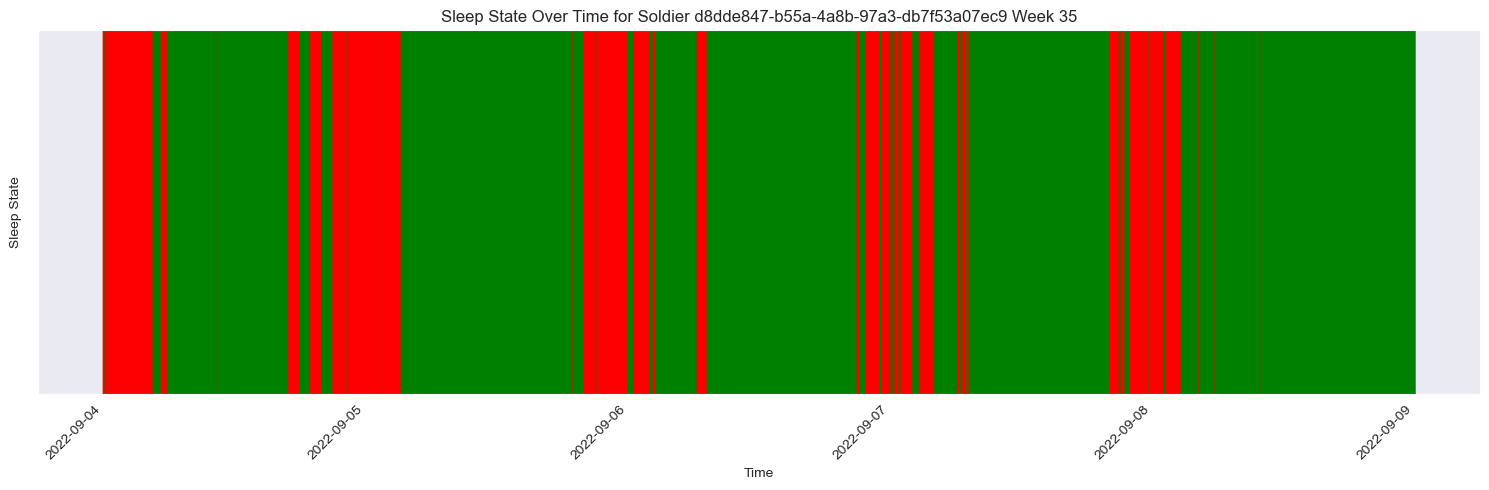

In [36]:
# plot a single graph: soldier & week_num

# Plotting
plt.figure(figsize=(15, 5))

weeks = completed_sleep[soldier].keys()

week = 35
to_plot = completed_sleep[soldier][week]

# Plot sleep state as blocks of color
# awake/0 in green
# sleeping/1 in red
for i, row in to_plot.iterrows():
    color = 'red' if row['SleepState'] == 1 else 'green'
    plt.fill_between([row['datetime'], row['datetime'] + timedelta(minutes=1)], 0, 1, color=color)

# Customize the plot
plt.xlabel('Time')
plt.ylabel('Sleep State')
plt.title(f'Sleep State Over Time for Soldier {soldier} Week {week}')
plt.yticks([0, 1], ['', ''])
plt.ylim(0, 1)

# Format x-axis for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.show()

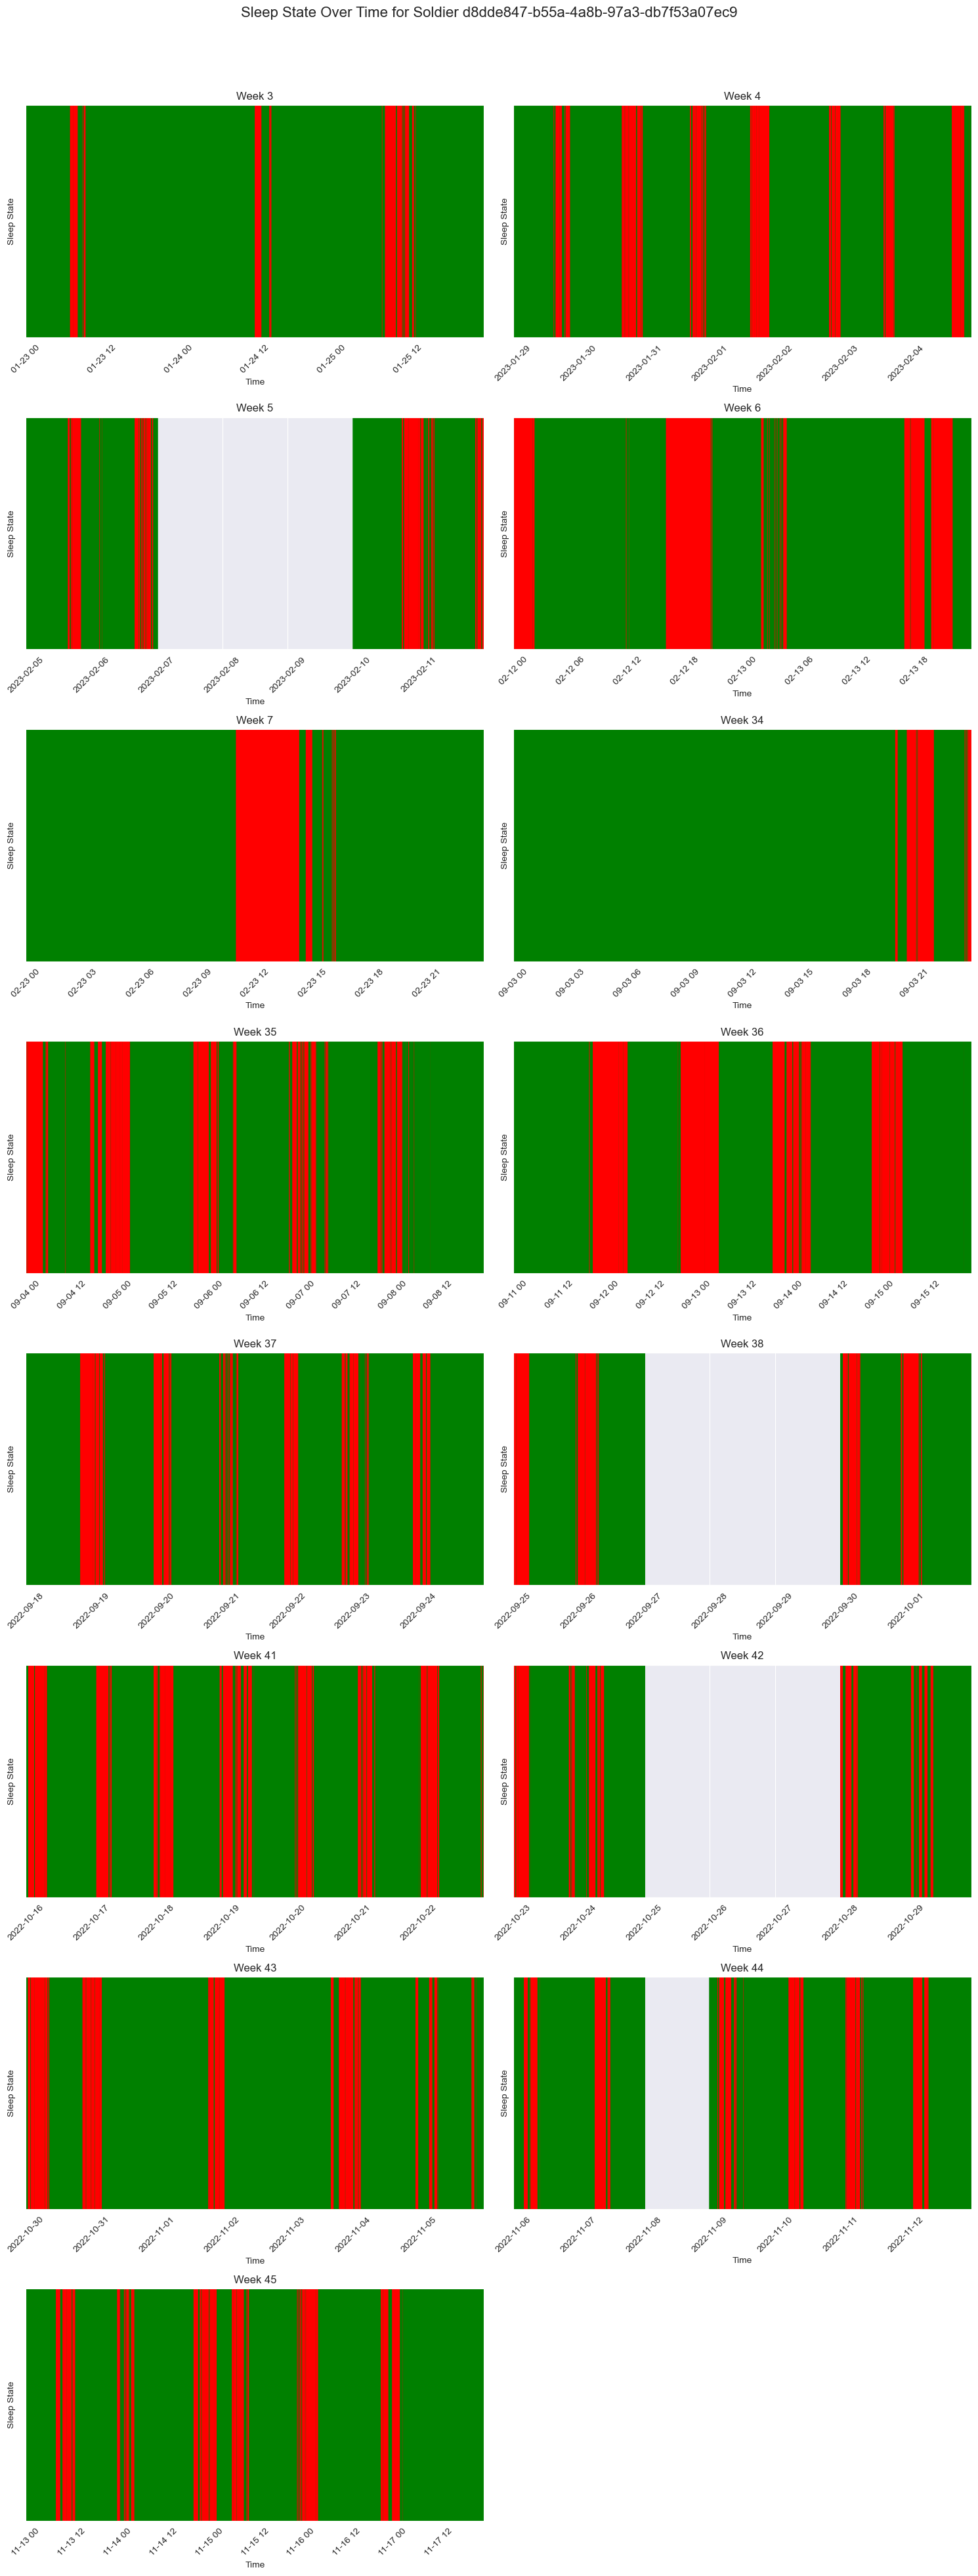

In [38]:
# plot all weeks for a soldier

# Determine the number of weeks to plot
weeks = list(completed_sleep[soldier].keys())
num_weeks = len(weeks)

# Create a grid of subplots
cols = 2  # number of columns in the grid
rows = (num_weeks + cols - 1) // cols  # calculate the number of rows needed

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows), sharey=True)

# Plot each week
for idx, week in enumerate(weeks):
    row = idx // cols
    col = idx % cols
    ax = axes[row, col]
    to_plot = completed_sleep[soldier][week]
    
    # Plot sleep state as blocks of color
    # awake/0 in green
    # sleeping/1 in red
    for i, row_data in to_plot.iterrows():
        color = 'red' if row_data['SleepState'] == 1 else 'green'
        ax.fill_between([row_data['datetime'], row_data['datetime'] + timedelta(minutes=1)], 0, 1, color=color)
    
    # Customize the plot
    ax.set_xlabel('Time')
    ax.set_ylabel('Sleep State')
    ax.set_title(f'Week {week}')
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['', ''])
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=45)
    ax.set_xlim(to_plot['datetime'].min(), to_plot['datetime'].max())

# Hide any empty subplots
for idx in range(num_weeks, rows * cols):
    fig.delaxes(axes.flatten()[idx])

fig.suptitle(f'Sleep State Over Time for Soldier {soldier}', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()